# Implementation of reinforcement learning with policy and value iteration algorithms
The source code is an implementation of reinforcement learning with policy and value iteration algorithms for minimum distance problems. The solved problem is the minimum distance on a grid space.  

### Note
This code was written as my Machine Learning course's assignment in the fall of 2021, so it may have some bugs to fix or be coded more optimally.

### GitHub
https://github.com/MohsenEbadpour/


In [1]:
from amalearn.reward import RewardBase
from amalearn.agent import AgentBase

In [2]:
from amalearn.environment import EnvironmentBase
import gym

from gym import spaces
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.rcParams["figure.figsize"] = (15,9)

In [3]:
# get the walls poitions
def GetObstacle():
    obs = []
    
    # down walls
    for i in range(5,6+1):
        for j in range(11,14+1):
            obs.append(np.array([j,i],dtype=int))
    
    # up walls
    for i in range(6,7+1):
        for j in range(0,3+1):
            obs.append(np.array([j,i],dtype=int))
            
    # right walls
    for i in range(12,14+1):
        for j in range(7,8+1):
            obs.append(np.array([j,i],dtype=int))
    """          
    # custom walls
    for i in range(4,14+1):
        for j in range(5,5+1):
            obs.append(np.array([j,i],dtype=int))
            
    # custom walls
    for i in range(0,9+1):
        for j in range(9,9+1):
            obs.append(np.array([j,i],dtype=int))
            
    """
    return np.array(obs,dtype=int)

In [4]:
class Environment(EnvironmentBase):
    
    def __init__(self, obstacle = [] ,id = 0, action_count=9, actionPrice = -0.01, goalReward = 1000, punish=-1, j_limit = 15, i_limit = 15, p = 0.8, container=None):
        """
        initialize your variables
        """        
        
        # we have a grid world to interact with it with size (i,j)
        self.j_limit = j_limit
        self.i_limit = i_limit
        state_space = spaces.Box(low=-1,high=action_count-1,shape=(i_limit,j_limit),dtype=np.int64)
        self.state_space = state_space
        
        # our possible actions are counted 9: 0 for stay and 1-8 for directions(1 top and go clockwise) 
        action_space = spaces.Discrete(9)
        self.action_space = action_space
        
        # save the obstacle(walls)
        self.obstacle = obstacle
        
        self.id = id
        
        self.actionPrice = actionPrice
        self.goalReward = goalReward
        self.punish = punish 
        self.p = p  
        self.action_count = action_count
        
        self.steps = 0        
        
        super(Environment, self).__init__(action_space, state_space, id, container)          
        
        
    def isStatePossible(self, state):
        """if given state is possible (not out of the grid and not obstacle) return ture"""
        # Check for obstacle
        if state in self.obstacle.tolist():
            return False
        
        # check for be in grid
        if state[0] < 0 or state[1] < 0 or state[0] >= self.i_limit or state[1] >= self.j_limit:
            return False
        
        return True
    
    def isAccessible(self, state, state_p):
        """if given state is Accesible (we can reach state_p by doing an action from state) return true"""    
        
        #first Check that both states are possible
        if not(self.isStatePossible(state) and self.isStatePossible(state_p)) :
            return False
        
        # check that states are neighbors of eachother
        if state_p[0] in np.arange(state[0]-1,state[0]+2,1) and state_p[1] in np.arange(state[1]-1,state[1]+2,1):
            return True
        else:
            return False
    
    def getTransitionStatesAndProbs(self, state, action, state_p):
        """return probability of transition or T(sp,a,s)"""
        
        if not self.action_space.contains(action):
            raise ValueError("Action value not accepted: {0}".format(action))
        
        #first check that Given states is accessible
        if not self.isAccessible(state,state_p):
            return 0
        
        # calculate that given action ends to given state
        if   state[0] == state_p[0] and state[1] == state_p[1]:
            _needed_action = 0
            
        elif state[0] - 1 == state_p[0] and state[1] == state_p[1]:
            _needed_action = 1
            
        elif state[0] - 1 == state_p[0] and state[1] + 1 == state_p[1] :
            _needed_action = 2
            
        elif state[0]  == state_p[0] and state[1] + 1 == state_p[1] :
            _needed_action = 3
            
        elif state[0] + 1 == state_p[0] and state[1] + 1 == state_p[1] :
            _needed_action = 4
            
        elif state[0] + 1 == state_p[0] and state[1] == state_p[1]:
            _needed_action = 5
            
        elif state[0] + 1 == state_p[0] and state[1] - 1 == state_p[1]:
            _needed_action = 6
            
        elif state[0]  == state_p[0] and state[1] -1 == state_p[1] :
            _needed_action = 7
            
        elif state[0] - 1  == state_p[0] and state[1] -1 == state_p[1] :
            _needed_action = 8
        
        # counting possible and accessible neighbors for source state
        CountOfAccessibleNeighbors = 0
        for i in np.arange(state[0]-1,state[0]+2,1):
            for j in np.arange(state[1]-1,state[1]+2,1):                
                if [i,j] in self.obstacle.tolist():
                    continue
                    
                elif i < 0 or j < 0 or i >= self.i_limit or j >= self.j_limit:
                    continue
                else:    
                    CountOfAccessibleNeighbors +=1         
        
        if action == _needed_action:
            return self.p
        else:
            # minus one from neighbors because actions are different
            CountOfAccessibleNeighbors -= 1
            return (1 - self.p)/CountOfAccessibleNeighbors
        
    
    def getReward(self, state, action, state_p):
        """return reward of transition"""  
        # check being correctly action
        if not self.action_space.contains(action):
            raise ValueError("Given Action is not defined: {0}".format(action))
        
        # Find reward
        for i in np.arange(state[0]-1,state[0]+2,1):
            for j in np.arange(state[1]-1,state[1]+2,1):
                if [i,j] != state_p:
                    continue
                if state_p in self.obstacle.tolist() or i < 0 or j < 0 or i >= self.i_limit or j >= self.j_limit:
                    return self.punish 
                
                elif state_p == [0,0]:
                    return self.goalReward 
                
                else:
                    return self.actionPrice
                
        raise ValueError("Given state are neighbors: {0}, {1}".format(state,state_p))                
        
        
        
    
    def sample_all_rewards(self):
        info = {"punish":self.punish,
                "goalReward":self.goalReward,
                 "actionPrice":self.actionPrice}
        return info
    
    def calculate_reward(self, action):
        # In our problem agent is not exploring environment. So, beside of environment, we do not have an action reward 
        # for a single action in entire of environment. so we do not need this function        
        return 

    def terminated(self):
        # Basically we do not need this function because we calculate termination condition in agent Iteration functions
        # and agent is not exploring environment
        # So, beside of environment, calculation is continuing -> terminated: False
        return False

    def observe(self): 
        return self.state

    def available_actions(self):
        # we use action_space variable to return available actions 
        return self.action_space.n

    def next_state(self, action): 
        self.steps += 1
        return

    def reset(self):
        # reset the changed variables, and initialize random state
        self.steps = 0
        self.state = self.state_space.sample()
        for i in range(self.i_limit):
            for j in range(self.j_limit):
                if not self.isStatePossible([i,j]):
                    self.state[i,j] = -1
                elif self.state[i,j] == -1:
                    self.state[i,j] = 0
        return self.state

    
    def render(self, mode='human'):
        # render the policy map
        print("----> Rendering Policy <---- | Walls indicated by (9)\n")
        for i in range(self.i_limit):
            for j in range(self.j_limit):
                action = self.state [i,j]
                print(action,end=" | ")
            print()
        return

    def close(self):
        # close and shutdown the environment
        return super(Environment, self).close()

In [5]:

class Agent(AgentBase):
    def __init__(self, id, environment, discount, theta):
        #initialize a random policy and V(s) = 0 for each state
        self.env = environment
        
        #init policy
        self.policy = self.env.reset()
        
        #init V(s) = 0
        self.V = np.zeros_like(self.policy,dtype=np.float64)
        self.V[0,0] = self.env.goalReward
        
        #mapp states to its ids, our states are grid which can reach them by indexes, so we do not need to map variable
        #self.mapp = {}
        
        # variable for check that an algorithm is calculated before 
        self.title = "Error"        
        
        super(Agent, self).__init__(id, environment)
        
        # store parameter
        self.discount = discount
        self.theta = theta
        
   
    # a custom function to control loop of evaluation and improvement steps in policy iteration
    def policy_iteration(self):
        #check that agent found the path or not
        if self.title != "Error" :
            print("An algorithm calculated before, Make new object of agent to calculate this algorithm")
            return
        Ite = 0
        flag = True
        while flag :
            Ite +=1
            
            # perform evaluation
            self.policy_evaluation() 
            
            # perform improvement
            flag = self.policy_improvement()
            
            # monitoring iterations
            print("Iteration passed #{0}".format(Ite))
        
        self.title = "Policy Iteration"
        # return plot and path lenght
        return Ite, self.plot_solution()          
            

    def policy_evaluation(self):        
        while True:
            delta = 0
            new_V = self.V.copy()
            
            # select source state (each state once in each iteration)            
            for i in range(self.env.i_limit):
                for j in range(self.env.j_limit):
                    
                    # store value of previous 
                    old_value = self.V[i,j]
                    new_value = 0  
                    
                    # assumed optimal policy
                    action = self.policy[i,j]
                    
                    
                    # check if source be the wall
                    if action == -1:
                        continue
                        
                    # calcularte new V(s)
                    for i_next in np.arange(i-1,i+2,1):
                        for j_next in np.arange(j-1,j+2,1):
                            # Calculation with environment function
                            prob =  self.env.getTransitionStatesAndProbs([i,j],action,[i_next,j_next])
                            reward = self.env.getReward([i,j],action,[i_next,j_next])
                            
                            if prob != 0:
                                new_value += prob*(reward + self.discount*self.V[i_next,j_next])  
                                                
                    # update the value   
                    new_V[i,j] = new_value  
                    
                    # updtae the exit condition
                    delta = max(delta,abs(new_value-old_value))                         
            
            # store new values                    
            self.V = new_V 
            
            # exit condition
            if delta < self.theta:
                break
                
    
    def policy_improvement(self):
        flag = False
        
        # explore each state
        for i in range(self.env.i_limit):
            for j in range(self.env.j_limit):
                    
                    # store value of previous action policy 
                    _max_value = self.V[i,j]
                    _action = self.policy[i,j]
                    
                    for action in range(self.env.action_count-1,-1,-1):
                        new_max = 0
                        
                        for i_next in np.arange(i-1,i+2,1):
                            for j_next in np.arange(j-1,j+2,1):
                                
                                # Calculation with environment function
                                prob =  self.env.getTransitionStatesAndProbs([i,j],action,[i_next,j_next])
                                reward = self.env.getReward([i,j],action,[i_next,j_next])
                                if prob != 0:
                                    new_max += prob*(reward + self.discount*self.V[i_next,j_next])
                        
                        # check if current action is better choice
                        if new_max > _max_value:
                            _max_value = new_max
                            _action = action
                            
                    # update policy and change the end-flag        
                    if self.policy[i,j] != _action:
                        flag = True
                        self.policy[i,j] = _action
                                       
        return flag
                
    
    def value_iteration(self):
        #check that agent found the path or not
        if self.title != "Error" :
            print("An algorithm calculated before, Make new object of agent to calculate this algorithm")
            return
        
        # check convegence and iteration
        Changing = True
        Ite = 0
        
        while Changing:
            delta = 0
            Ite +=1
            Changing = False
            new_V = self.V.copy()
            
            # select source state (each state once in each iteration)            
            for i in range(self.env.i_limit):
                for j in range(self.env.j_limit):
                    # store value of previous 
                    old_value = self.V[i,j]
                    _max_value = self.V[i,j]
                    _action = -1
                    
                    # select an action
                    for action in range(self.env.action_count-1,-1,-1):
                        new_value = 0
                        
                        #select next state | calculate reward for each action and pick up the best
                        for i_next in np.arange(i-1,i+2,1):
                            for j_next in np.arange(j-1,j+2,1):
                                
                                # Calculation with environment function
                                prob =  self.env.getTransitionStatesAndProbs([i,j],action,[i_next,j_next])
                                reward = self.env.getReward([i,j],action,[i_next,j_next])
                                if prob != 0:
                                    new_value += prob*(reward + self.discount*self.V[i_next,j_next])
                        
                        # check if given action is better choice
                        if new_value > _max_value:
                            _max_value = new_value
                            _action = action
                    
                    # updtae the exit condition
                    delta = max(delta,abs(_max_value-old_value)) 
                            
                    if delta > self.theta:
                        Changing = True
                    
                    # check if changed
                    if _action != -1:
                        new_V[i,j] = _max_value
                        self.policy[i,j] = _action
                        
            self.V = new_V 
            
            # monitoring iterations
            if Ite % 5 == 0:
                print("Iteration passed #{0}".format(Ite))
                print("Delta is:",delta)
            # Set name of calculated algorithm
        self.title = "Value Iteration"
        
        # plot and return the result
        return Ite, self.plot_solution()
                        
      
    # a custom function to plot solution
    def plot_solution(self, i=14,j=14):
        # check if one algorithm calculated before
        if self.title == "Error":
            raise ValueError("First run one of algorithms")
        
        # chech source situation
        if not(self.env.isStatePossible([i,j])) :
            raise ValueError("Given source to solve is wall!")
            
        plt.imshow(-(self.V), cmap='GnBu', alpha=0.5)
        #plt.axis(False)
        X = []
        Y = []
        
        # storing path from source to goal reward
        while i != 0 or j != 0:
            Y.append(i)
            X.append(j)

            if self.policy[i,j] == 0 :
                break
            elif self.policy[i,j] == 1 : 
                i -= 1
            elif self.policy[i,j] == 2 : 
                i -= 1
                j += 1
            elif self.policy[i,j] == 3 : 
                j += 1  
            elif self.policy[i,j] == 4 : 
                i += 1
                j += 1
            elif self.policy[i,j] == 5 : 
                i += 1 
            elif self.policy[i,j] == 6 : 
                i += 1
                j -= 1
            elif self.policy[i,j] == 7 : 
                j -= 1
            elif self.policy[i,j] == 8 : 
                i -= 1
                j -= 1 
            else :
                raise ValueError("Given source to solve is wall!")

        X.append(0)
        Y.append(0)

        plt.plot(X,Y,color="red")
        plt.title("{4} Algorithm | Discount Factor:{0} | Theta:{1} | Punish:{2} | Action Price:{3}".format(self.discount,
                                                                                                          self.theta,
                                                                                                          self.env.punish,
                                                                                                          self.env.actionPrice,
                                                                                                          self.title))
        plt.show()
        
        return len(X)
    
    # a custom function to value function
    def plot_value_function(self):
        # check if one algorithm calculated before
        if self.title == "Error":
            raise ValueError("First run one of algorithms")        
        sns.heatmap(self.V, cmap='viridis', annot=True, fmt=".2f")  
        plt.title("Value Function | {4} Algorithm | Discount Factor:{0} | Theta:{1} | Punish:{2} | Action Price:{3}".format(self.discount,
                                                                                                          self.theta,
                                                                                                          self.env.punish,
                                                                                                          self.env.actionPrice,
                                                                                                          self.title))
        plt.show()
           

    
    def take_action(self) -> (object, float, bool, object):
        # NOTE: based on documentaion(amalearn->gym) this function in its body should call "step(action)" function and pass an action to it.
        # then it returns parameters(it excatly likes to (object, float, bool, object)) => I mean that i found the usages.
        # but in our problem agent is not exploring the envrionment, so we do not call step function because
        # we are using directly with getReward() and getTransitionStatesAndProbs() functions that is given us in Environment Class
        pass
        
        
        
        
    

# 1

Iteration passed #1
Iteration passed #2
Iteration passed #3
Iteration passed #4
Iteration passed #5
Iteration passed #6
Iteration passed #7


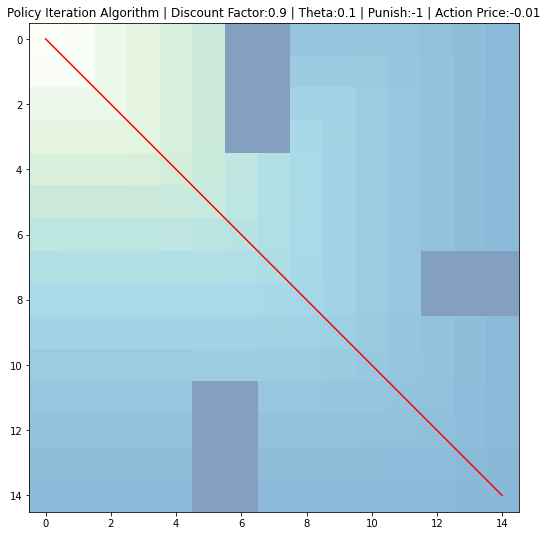

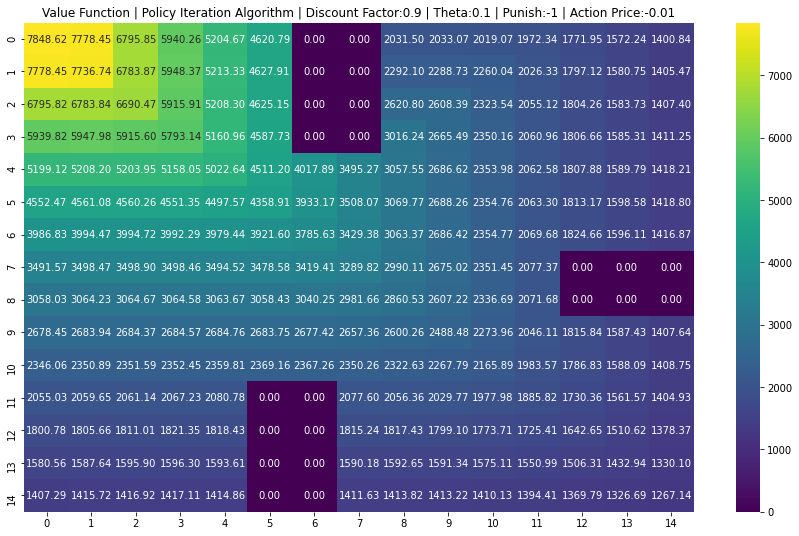

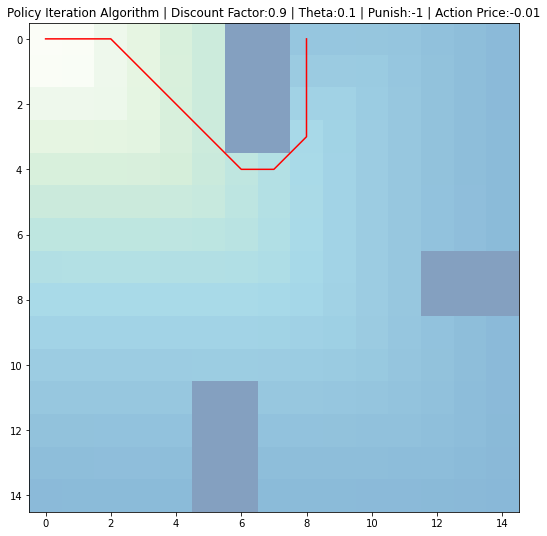

12

In [13]:
obs = GetObstacle()
env0 = Environment(obs)
agnt = Agent(0,env0,0.9,0.1)
agnt.policy_iteration()
agnt.plot_value_function()
agnt.plot_solution(0,8)

# 2

Iteration passed #1
Iteration passed #2
Iteration passed #3
Iteration passed #4
Iteration passed #5
Iteration passed #6
Iteration passed #7


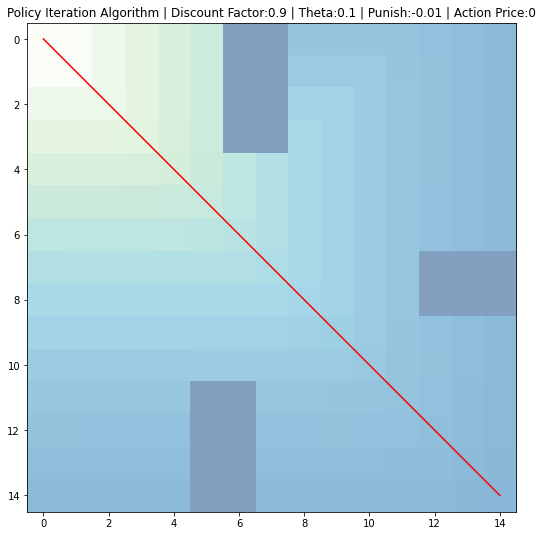

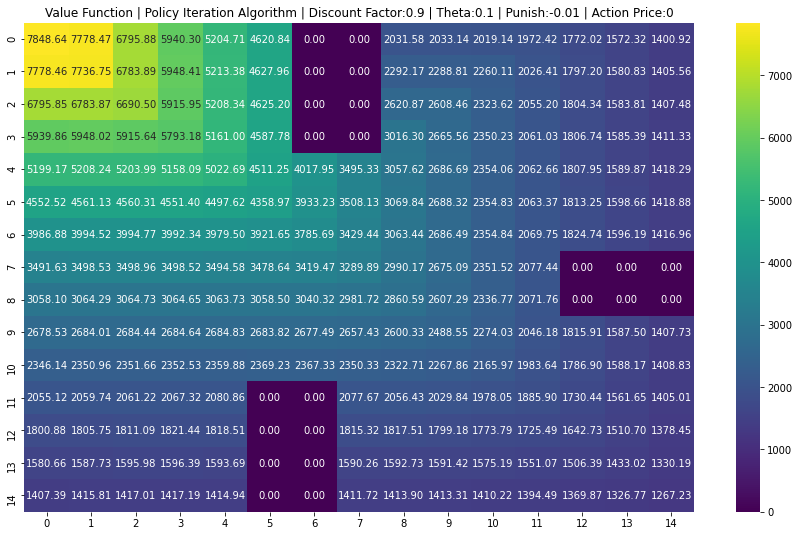

In [7]:
env1 = Environment(obs,actionPrice=0,punish=-0.01)
agnt1 = Agent(0,env1,0.9,0.1)
agnt1.policy_iteration()
agnt1.plot_value_function()

# 3

Iteration passed #1
Iteration passed #2
Iteration passed #3
Iteration passed #4
Iteration passed #5
Iteration passed #6
Iteration passed #7
Iteration passed #8


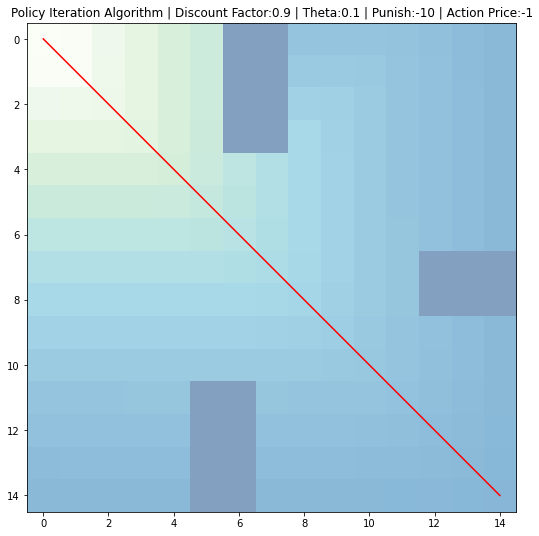

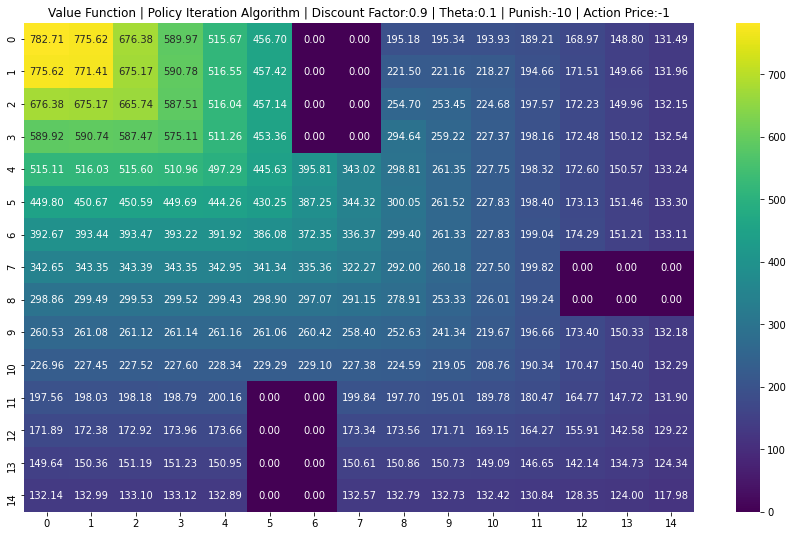

In [8]:
env2 = Environment(obs,actionPrice=-1,punish=-10,goalReward=100)
agnt2 = Agent(0,env2,0.9,0.1)
agnt2.policy_iteration()
agnt2.plot_value_function()

# 4

Iteration passed #1
Iteration passed #2
Iteration passed #3
Iteration passed #4
Iteration passed #5
Iteration passed #6
Iteration passed #7


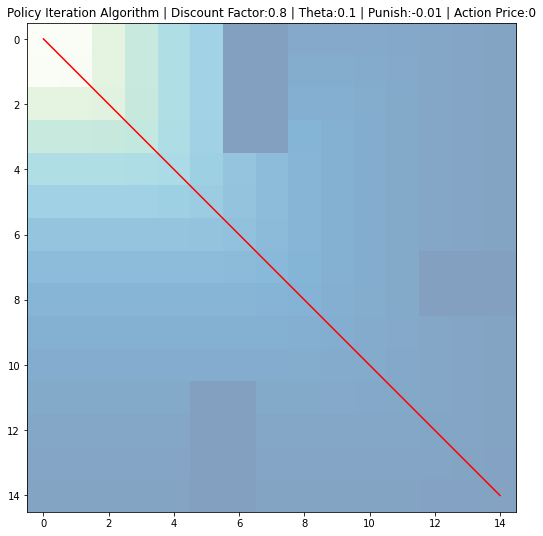

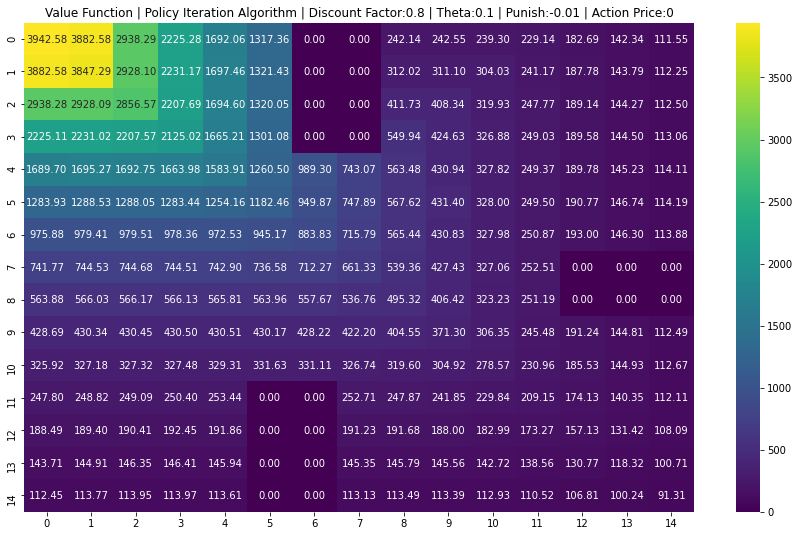

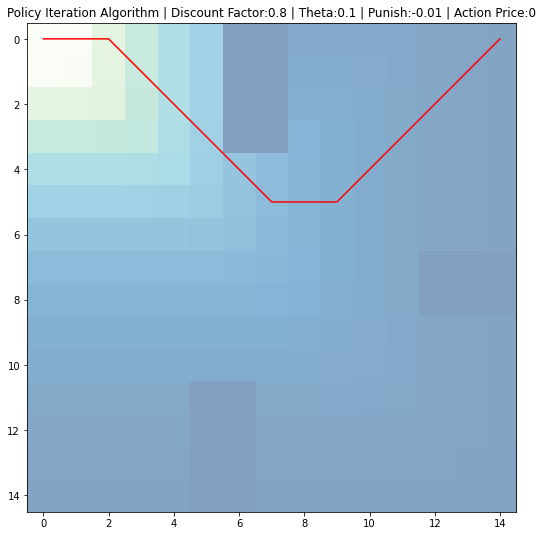

Iteration passed #1
Iteration passed #2
Iteration passed #3
Iteration passed #4
Iteration passed #5
Iteration passed #6
Iteration passed #7


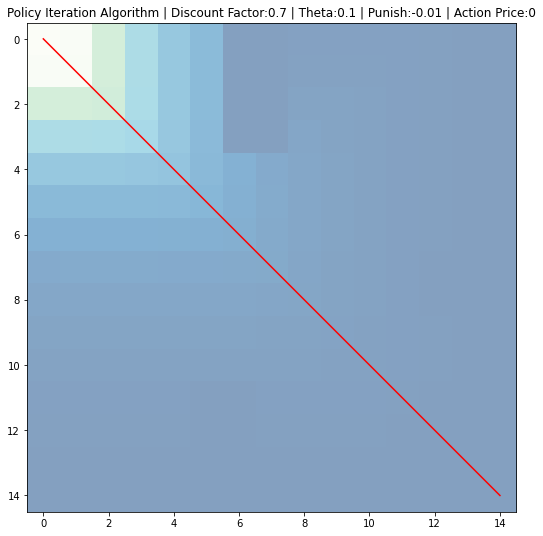

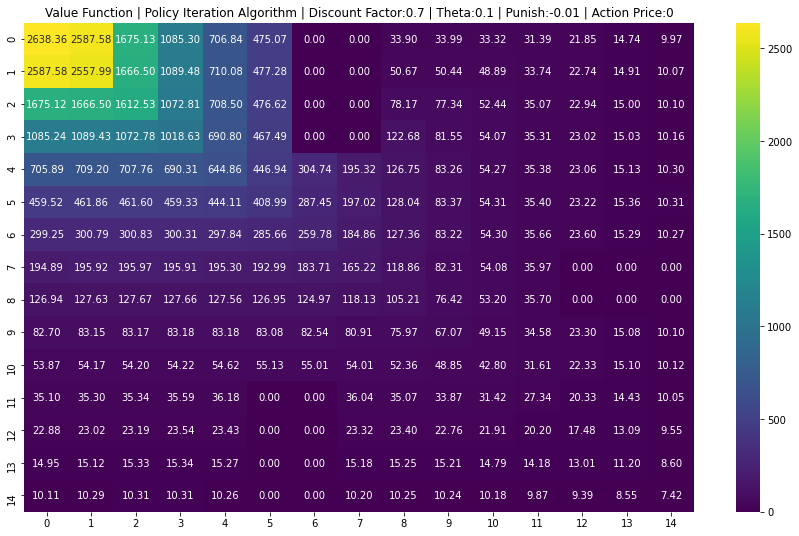

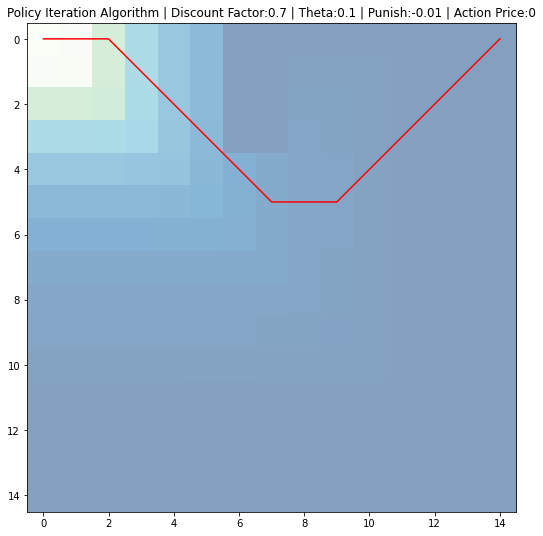

Iteration passed #1
Iteration passed #2
Iteration passed #3
Iteration passed #4
Iteration passed #5
Iteration passed #6
Iteration passed #7


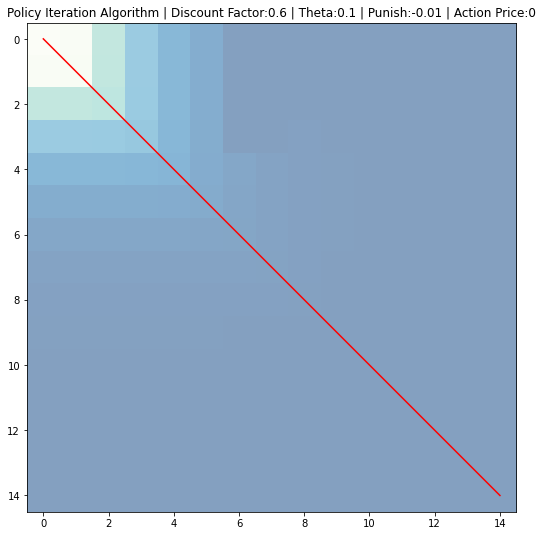

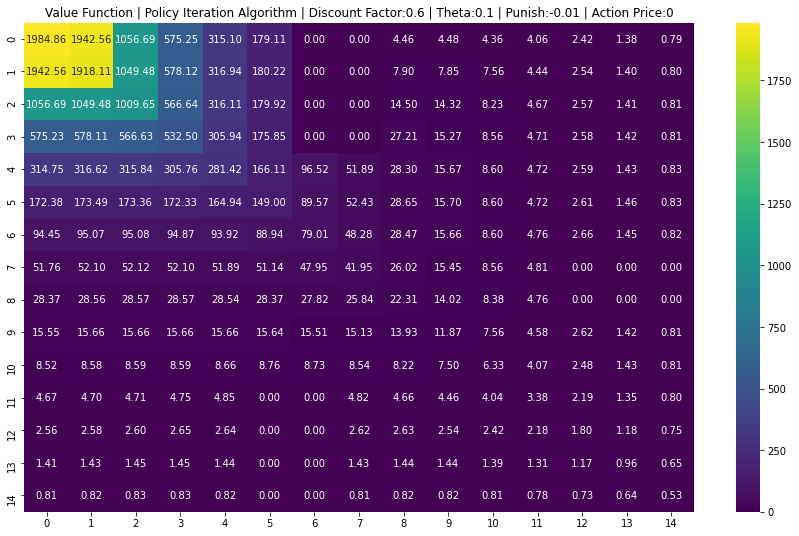

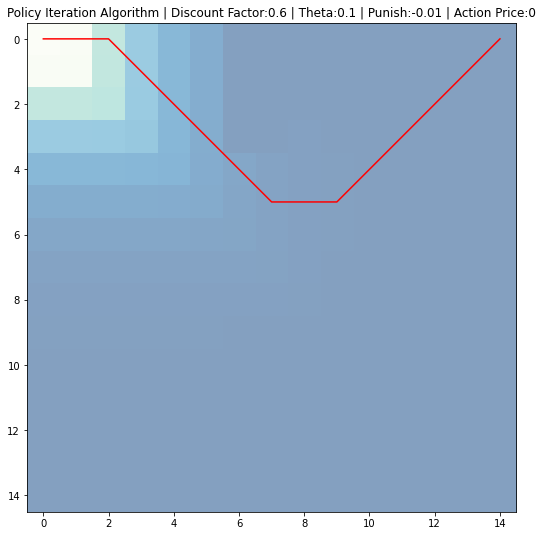

Iteration passed #1
Iteration passed #2
Iteration passed #3
Iteration passed #4
Iteration passed #5


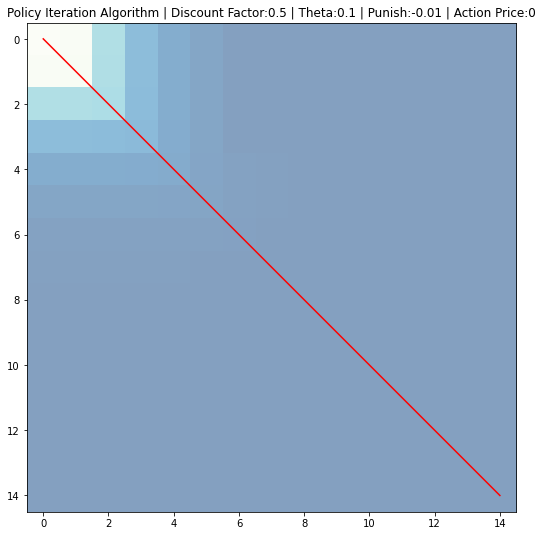

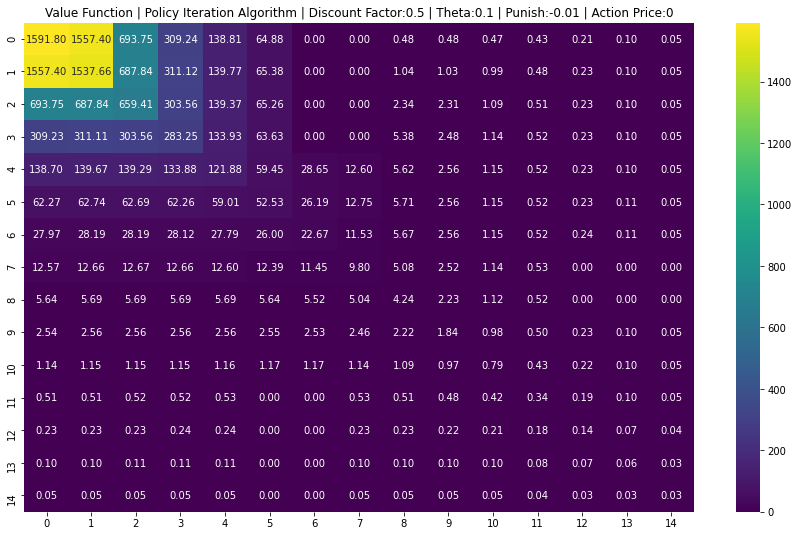

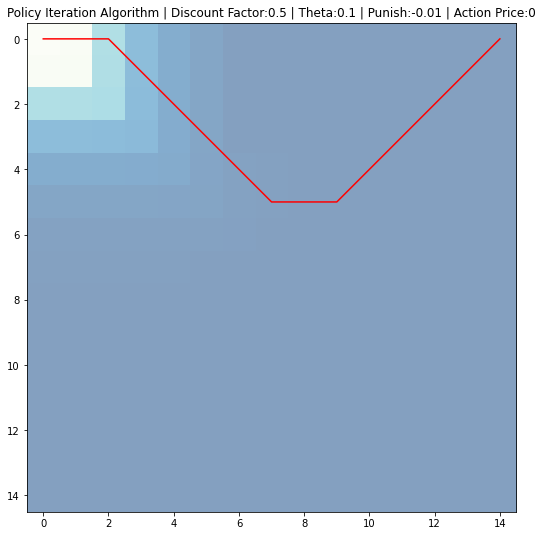

Iteration passed #1
Iteration passed #2
Iteration passed #3
Iteration passed #4
Iteration passed #5


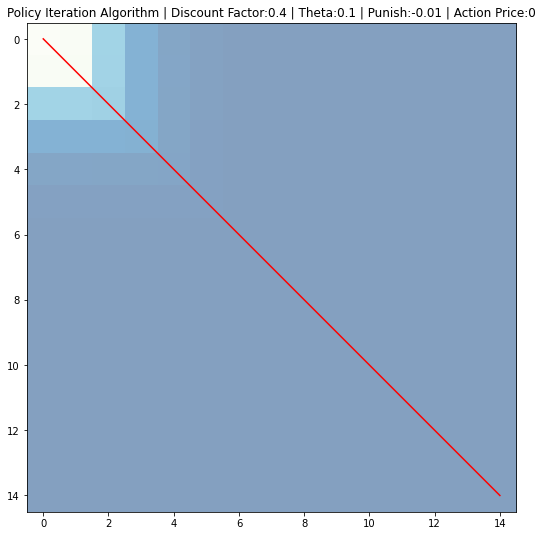

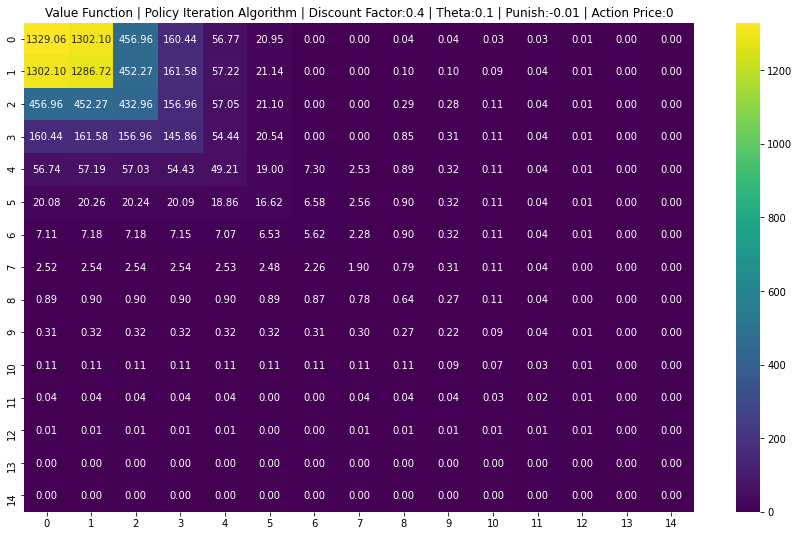

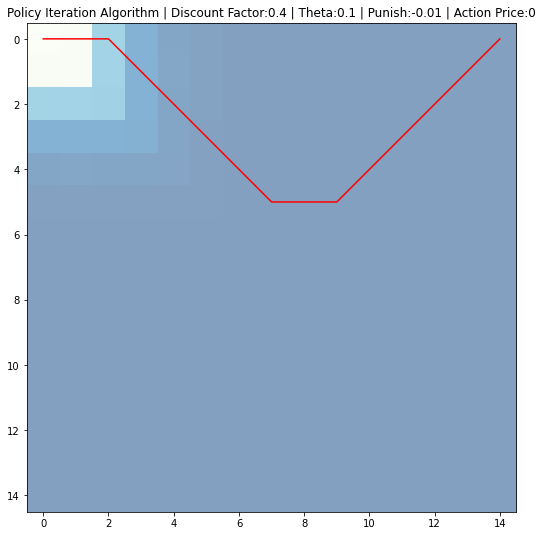

Iteration passed #1
Iteration passed #2
Iteration passed #3
Iteration passed #4
Iteration passed #5
Iteration passed #6
Iteration passed #7
Iteration passed #8
Iteration passed #9


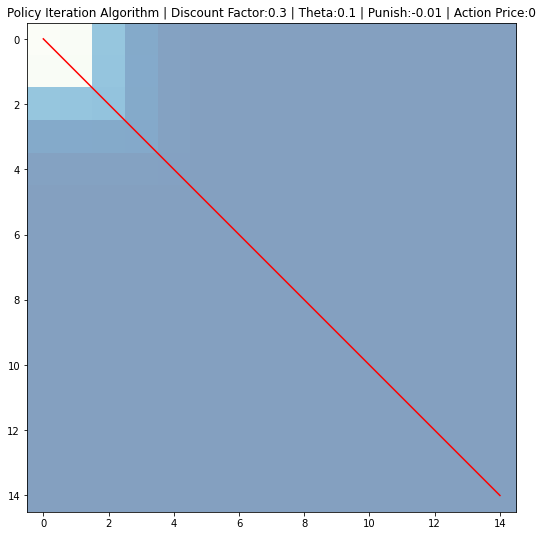

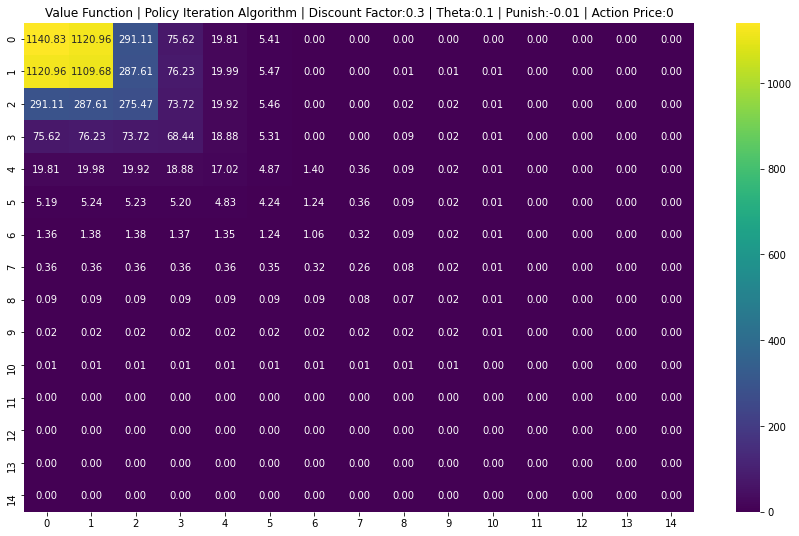

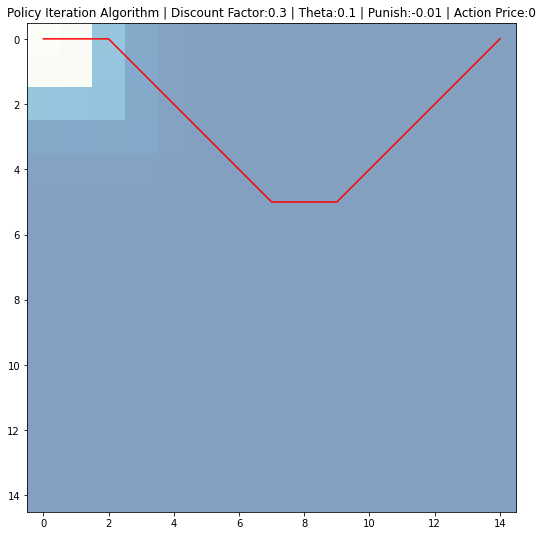

Iteration passed #1
Iteration passed #2
Iteration passed #3
Iteration passed #4
Iteration passed #5
Iteration passed #6
Iteration passed #7
Iteration passed #8
Iteration passed #9
Iteration passed #10


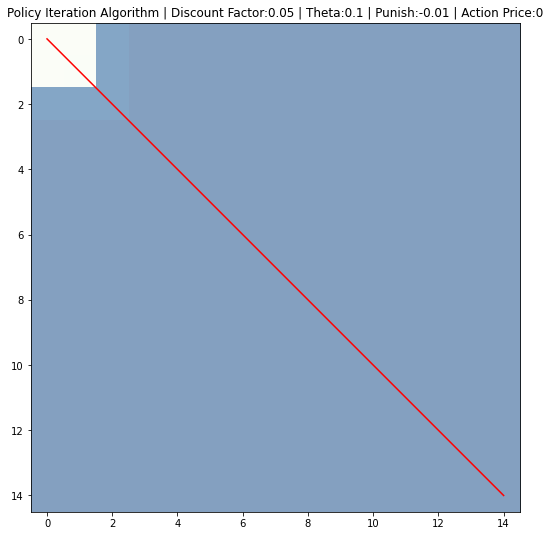

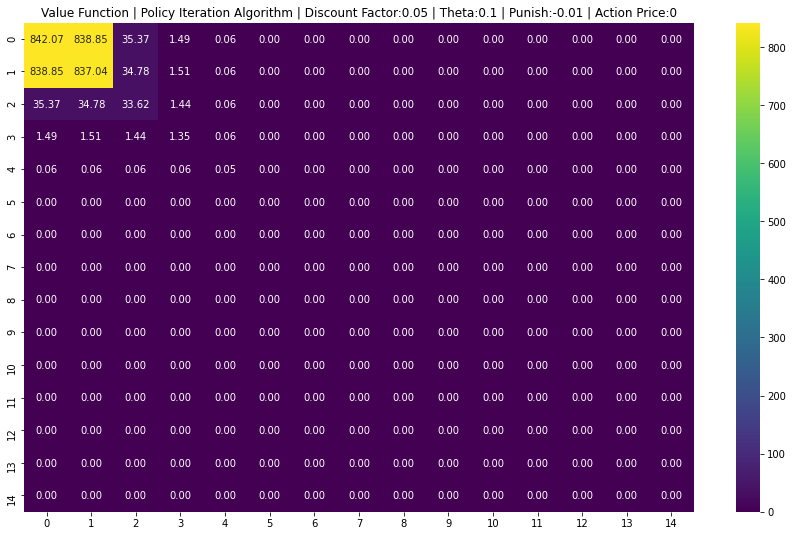

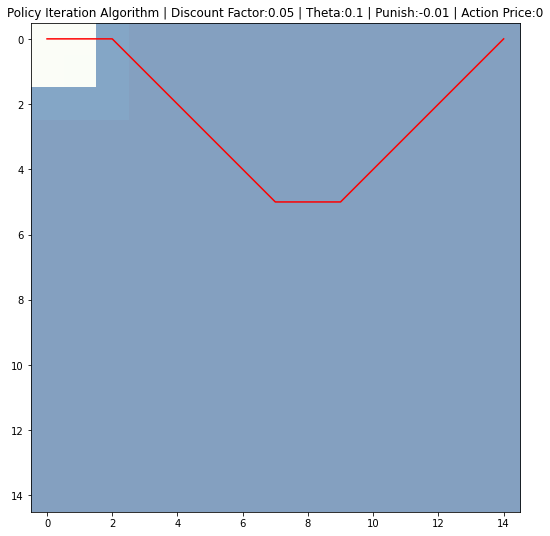

In [14]:
dis_fac = [0.8,0.7,0.6,0.5,0.4,0.3,0.05]
for fac in dis_fac:
    env3 = Environment(obs,actionPrice=0,punish=-0.01)
    agnt3 = Agent(0,env3,fac,0.1)
    agnt3.policy_iteration()
    agnt3.plot_value_function()
    agnt3.plot_solution(0,14)

# 5

Iteration passed #5
Delta is: 313.6641270386687
Iteration passed #10
Delta is: 84.47904347351812
Iteration passed #15
Delta is: 27.462745925894524
Iteration passed #20
Delta is: 8.997538020956995
Iteration passed #25
Delta is: 2.948298199577721
Iteration passed #30
Delta is: 0.9660981897650345
Iteration passed #35
Delta is: 0.31657105294061694
Iteration passed #40
Delta is: 0.103734002605961


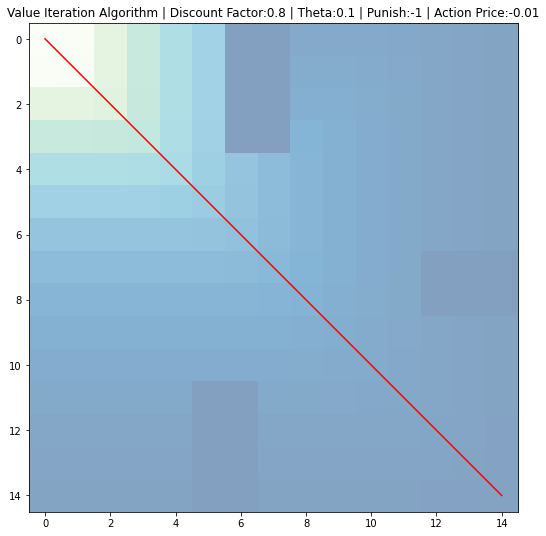

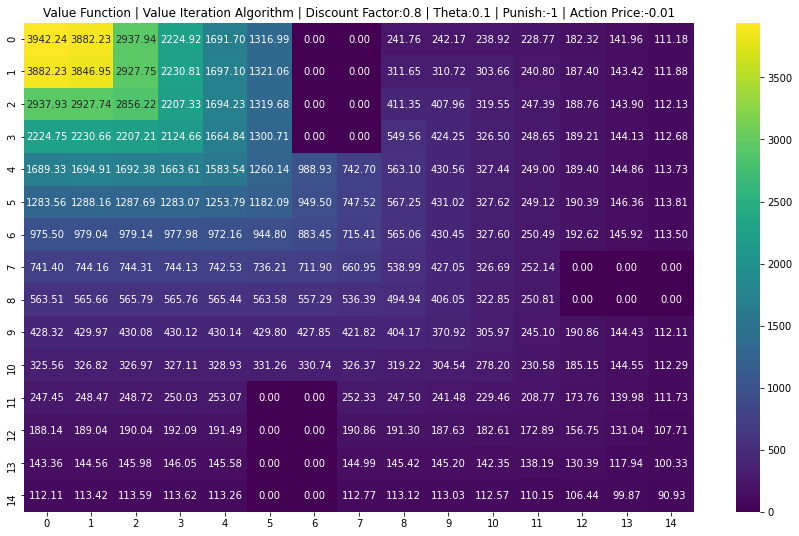

In [12]:
env2 = Environment(obs)
agnt2 = Agent(0,env2,0.8,0.1)
agnt2.value_iteration()
agnt2.plot_value_function()

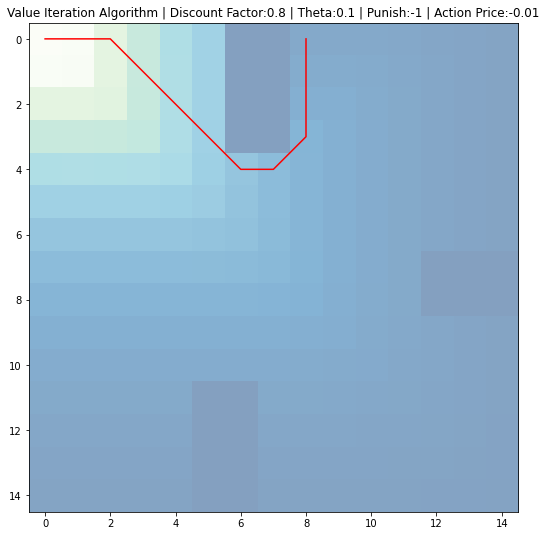

12

In [21]:
agnt2.plot_solution(0,8)